In [1]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [65]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [64]:
# 이미지 마크다운용 함수
def get_imgmd(imageURL):
    newURL = imageURL[:25]+'uc?id='+ imageURL[32:-17]
    get_mk = '![img](' + newURL + ')'

    return get_mk

# 2장 서울시 범죄 현황 분석

강남 3구의 체감 안전도가 높다는 기사를 검증하려 합니다. 

## 2-1 데이터 획득하기

구글에서 '서울시 관서별 5대 범죄 발생 검거 현황'으로 검색해도 되고, data.go.kr 에서 공공데이터 포럼으로 원하는 데이터를 다운받습니다.

## 2-2 pandas를 이요한 데이터 정리하기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

다운받은 데이터를 pandas로 읽어, "crime_anal_police" 라는 변수에 저장합니다.
- 그 내용에는 서울시 경찰서별로 살인, 강도, 강간, 절도, 폭력 이라는 5대 범죄에 발생 건수와 검거 건수를 가지고 있습니다.

In [5]:
crime_anal_police = pd.read_csv('/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/02. crime_in_Seoul.csv', thousands = ',', encoding = 'cp949')

crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170
1,종로서,3,3,6,5,115,98,1070,413,1278,1070
2,남대문서,1,0,6,4,65,46,1153,382,869,794
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711
4,혜화서,3,2,5,4,96,63,1114,424,1015,861


여기서 문제가 하나 발생합니다. 우리는 강남 3구가 안전한지를 확인해야 하는데, 데이터가 관서별로 되어있습니다. 서울시에는 한 구에 하나 혹은 두 군데의 경찰서가 위치해 있고, 구 이름과 다른 경찰서도 있습니다. 이 결찰서 목록을 소속 구별로 변경하고 싶습니다. 그러기 위해서는 먼저 경찰서 이름으로 구 정보를 알아야합니다. 양이 많지 않으니 직접해도 되지만, **<u>우리는 프로그램으로 접근하도록 하겠습니다.</u>**

## 2-3 지도 정보를 얻을 수 있는 Google Maps

Google Maps API는 구글에서 제공하는 서비스로, 위치에 대한 검색 결과 중 주소와 위도, 경도 정보를 제공합니다. 
- https://developers.google.com/maps/?hl=ko
- Google Maps API -> Google Maps Geocoding API(지오코딩) -> '키 가져오기'
- `pip install googlemaps`라는 명령어로 파이썬에서 googlemaps를 사용할 수 있도록 합니다.


In [6]:
pip install googlemaps

  Created wheel for googlemaps: filename=googlemaps-4.6.0-py3-none-any.whl size=38554 sha256=1d786a9780ef1e362ca479d20ed8ad9b93cc5a04fa6ca4656387e08114a2833a
  Stored in directory: /root/.cache/pip/wheels/80/db/c0/6d958585fa97b20e250bf437acf7e6e715b4809c2dd4e55367
Successfully built googlemaps


## 2-4 Google Maps를 이용해서 주소와 위도, 경도 정보 얻기

In [7]:
maps_key = pd.read_csv('/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/GoogleAPIKey.txt')
maps_key = maps_key.columns[0] #공개되면 안되는 나의 GoogleMaps API key

In [8]:
import googlemaps

`googlemaps.Client`로 키를 입력합니다. key는, Google Maps API에서 제공받은 key를 사용합니다.

In [9]:
gmaps_key = maps_key
gmaps = googlemaps.Client(key = gmaps_key)

Google Maps를 사용해서 '서울중부경찰서' 라는 단어를 검색하면, `formatted_address`항목에 주소가 나오고, `lng`와 `lat`에서 위도 경도 정보 또한 확인할 수 있습니다.

In [10]:
gmaps.geocode('서울중부경찰서', language='ko')

[{'address_components': [{'long_name': '２７',
    'short_name': '２７',
    'types': ['premise']},
   {'long_name': '수표로',
    'short_name': '수표로',
    'types': ['political', 'sublocality', 'sublocality_level_4']},
   {'long_name': '중구',
    'short_name': '중구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '100-032',
    'short_name': '100-032',
    'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 중구 수표로 27',
  'geometry': {'location': {'lat': 37.56361709999999, 'lng': 126.9896517},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.5649660802915,
     'lng': 126.9910006802915},
    'southwest': {'lat': 37.5622681197085, 'lng': 126.9883027197085}}},
  'partial_match': True,
  'place_id': 'ChIJc-9q5uSifDURLhQmr5wkXmc',
 

In [11]:
print(gmaps.geocode('서울중부경찰서', language='ko')[0].get('formatted_address'))
print(gmaps.geocode('서울중부경찰서', language='ko')[0].get('geometry'))
print(gmaps.geocode('서울중부경찰서', language='ko')[0].get('geometry')['location']['lat'])
print(gmaps.geocode('서울중부경찰서', language='ko')[0].get('geometry')['location']['lng'])

대한민국 서울특별시 중구 수표로 27
{'location': {'lat': 37.56361709999999, 'lng': 126.9896517}, 'location_type': 'ROOFTOP', 'viewport': {'northeast': {'lat': 37.5649660802915, 'lng': 126.9910006802915}, 'southwest': {'lat': 37.5622681197085, 'lng': 126.9883027197085}}}
37.56361709999999
126.9896517


하지만, 위의 `crime_anal_police`의 관서명을 보면, 중부서, 종로서 등으로 되어있습니다. 그러면 구글검색에서 주소가 제대로 나오지 않기 때문에, 서울**경찰서로 만들어야 겠습니다.

In [12]:
station_name = []

for name in crime_anal_police['관서명']:
    station_name.append('서울' + str(name[:-1])+ '경찰서')

station_name

['서울중부경찰서',
 '서울종로경찰서',
 '서울남대문경찰서',
 '서울서대문경찰서',
 '서울혜화경찰서',
 '서울용산경찰서',
 '서울성북경찰서',
 '서울동대문경찰서',
 '서울마포경찰서',
 '서울영등포경찰서',
 '서울성동경찰서',
 '서울동작경찰서',
 '서울광진경찰서',
 '서울서부경찰서',
 '서울강북경찰서',
 '서울금천경찰서',
 '서울중랑경찰서',
 '서울강남경찰서',
 '서울관악경찰서',
 '서울강서경찰서',
 '서울강동경찰서',
 '서울종암경찰서',
 '서울구로경찰서',
 '서울서초경찰서',
 '서울양천경찰서',
 '서울송파경찰서',
 '서울노원경찰서',
 '서울방배경찰서',
 '서울은평경찰서',
 '서울도봉경찰서',
 '서울수서경찰서']

다음은 위 코드에서 만들어진 이름을 이용하여 googlemaps에서 주소를 받아옵니다.

- '서울종암경찰서'에서 계속 에러가 나서, geocode에러를 찾아보아도 명확한 해결이 되지않아서, 우선 '서울종암경찰' 로 대체하는것으로 통과시켰다.

In [13]:
station_address = []
station_lat = []
station_lng = []

for name in station_name:
    try:
        tmp = gmaps.geocode(name, language = 'ko')
        station_address.append(tmp[0].get("formatted_address"))

        tmp_loc = tmp[0].get('geometry')

        station_lat.append(tmp_loc['location']['lat'])
        station_lng.append(tmp_loc['location']['lat'])

        print(name + ' --> ' + tmp[0].get("formatted_address"))
    except:
        print("error at ",name)
        tmp = gmaps.geocode(name[:-1], language = 'ko')
        station_address.append(tmp[0].get("formatted_address"))

        tmp_loc = tmp[0].get('geometry')

        station_lat.append(tmp_loc['location']['lat'])
        station_lng.append(tmp_loc['location']['lat'])

        print(name[:-1] + ' --> ' + tmp[0].get("formatted_address"))
        continue

서울중부경찰서 --> 대한민국 서울특별시 중구 수표로 27
서울종로경찰서 --> 대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46
서울남대문경찰서 --> 대한민국 서울특별시 중구 한강대로 410
서울서대문경찰서 --> 대한민국 서울특별시 서대문구 통일로 113
서울혜화경찰서 --> 대한민국 서울특별시 종로구 창경궁로 112-16
서울용산경찰서 --> 대한민국 서울특별시 용산구 백범로 329
서울성북경찰서 --> 대한민국 서울특별시 성북구 삼선동 보문로 170
서울동대문경찰서 --> 대한민국 서울특별시 동대문구 약령시로21길 29
서울마포경찰서 --> 대한민국 서울특별시 마포구 마포대로 183
서울영등포경찰서 --> 대한민국 서울특별시 영등포구 당산동3가 국회대로 608
서울성동경찰서 --> 대한민국 서울특별시 성동구 행당동 왕십리광장로 9
서울동작경찰서 --> 대한민국 서울특별시 동작구 노량진로 148
서울광진경찰서 --> 대한민국 서울특별시 광진구 구의동 자양로 167
서울서부경찰서 --> 대한민국 서울특별시 은평구 녹번동 177-15
서울강북경찰서 --> 대한민국 서울특별시 강북구 오패산로 406
서울금천경찰서 --> 대한민국 서울특별시 금천구 시흥대로73길 50
서울중랑경찰서 --> 대한민국 서울특별시 중랑구 묵2동 249-2
서울강남경찰서 --> 대한민국 서울특별시 강남구 테헤란로114길 11
서울관악경찰서 --> 대한민국 서울특별시 관악구 관악로5길 33
서울강서경찰서 --> 대한민국 서울특별시 강서구 화곡6동 980-27
서울강동경찰서 --> 대한민국 서울특별시 강동구 성내로 57
error at  서울종암경찰서
서울종암경찰 --> 대한민국 서울특별시 성북구 종암동
서울구로경찰서 --> 대한민국 서울특별시 구로구 가마산로 235
서울서초경찰서 --> 대한민국 서울특별시 서초구 서초3동 반포대로 179
서울양천경찰서 --> 대한민국 서울특별시 양천구 목동동로 99
서울송파경찰서 --> 대한민국 서울특별시 송파구 중대로 221
서울노원경찰서 

저장 된 전체 주소를 확인합니다.

In [14]:
station_address

['대한민국 서울특별시 중구 수표로 27',
 '대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46',
 '대한민국 서울특별시 중구 한강대로 410',
 '대한민국 서울특별시 서대문구 통일로 113',
 '대한민국 서울특별시 종로구 창경궁로 112-16',
 '대한민국 서울특별시 용산구 백범로 329',
 '대한민국 서울특별시 성북구 삼선동 보문로 170',
 '대한민국 서울특별시 동대문구 약령시로21길 29',
 '대한민국 서울특별시 마포구 마포대로 183',
 '대한민국 서울특별시 영등포구 당산동3가 국회대로 608',
 '대한민국 서울특별시 성동구 행당동 왕십리광장로 9',
 '대한민국 서울특별시 동작구 노량진로 148',
 '대한민국 서울특별시 광진구 구의동 자양로 167',
 '대한민국 서울특별시 은평구 녹번동 177-15',
 '대한민국 서울특별시 강북구 오패산로 406',
 '대한민국 서울특별시 금천구 시흥대로73길 50',
 '대한민국 서울특별시 중랑구 묵2동 249-2',
 '대한민국 서울특별시 강남구 테헤란로114길 11',
 '대한민국 서울특별시 관악구 관악로5길 33',
 '대한민국 서울특별시 강서구 화곡6동 980-27',
 '대한민국 서울특별시 강동구 성내로 57',
 '대한민국 서울특별시 성북구 종암동',
 '대한민국 서울특별시 구로구 가마산로 235',
 '대한민국 서울특별시 서초구 서초3동 반포대로 179',
 '대한민국 서울특별시 양천구 목동동로 99',
 '대한민국 서울특별시 송파구 중대로 221',
 '대한민국 서울특별시 노원구 하계동 노원로 283',
 '대한민국 서울특별시 서초구 동작대로 204',
 '대한민국 서울특별시 은평구 불광동 연서로 365',
 '대한민국 서울특별시 도봉구 노해로 403',
 '대한민국 서울특별시 강남구 개포로 617']

In [15]:
station_lat

[37.56361709999999,
 37.575548,
 37.5547584,
 37.5647439,
 37.5719679,
 37.5387099,
 37.58977830000001,
 37.58506149999999,
 37.550814,
 37.5260441,
 37.5617303,
 37.5130866,
 37.542873,
 37.6021405,
 37.63730390000001,
 37.4568722,
 37.6056429,
 37.5094352,
 37.4743945,
 37.551284,
 37.528511,
 37.60017089999999,
 37.494931,
 37.4956054,
 37.5167711,
 37.5016941,
 37.6425238,
 37.4945959,
 37.6283178,
 37.6533589,
 37.49349]

In [16]:
station_lng

[37.56361709999999,
 37.575548,
 37.5547584,
 37.5647439,
 37.5719679,
 37.5387099,
 37.58977830000001,
 37.58506149999999,
 37.550814,
 37.5260441,
 37.5617303,
 37.5130866,
 37.542873,
 37.6021405,
 37.63730390000001,
 37.4568722,
 37.6056429,
 37.5094352,
 37.4743945,
 37.551284,
 37.528511,
 37.60017089999999,
 37.494931,
 37.4956054,
 37.5167711,
 37.5016941,
 37.6425238,
 37.4945959,
 37.6283178,
 37.6533589,
 37.49349]

이제, 저장한 주소를, 띄어쓰기, 공백으로 나누고(split) 두 번쨰 단어(얼핏보니 구이름)를 선택해서 '구별'이라는 컬럼으로 저장합니다. 이렇게하면 관서명에서 google maps의 도움을 받아 구별 이름으로 저장할 수 있게 되었습니다.

In [17]:
gu_name = []
for name in station_address:
    tmp = name.split()

    tmp_gu = [gu for gu in tmp if gu[-1] == '구'][0]

    gu_name.append(tmp_gu)

crime_anal_police['구별'] = gu_name
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


~~단, 금천경찰서의 경우에는 관악구에 위치 해 있어서, 금천서는 예외처리를 해야합니다.~~ 책에서는 그렇게 하였으나, 내겐 이미 업데이트 되어있어서 통과.

In [18]:
crime_anal_police[crime_anal_police['관서명']=='금천서']

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
15,금천서,3,4,6,6,151,122,1567,888,2054,1776,금천구


~~관악구로 되어있는것을 금천구로 변경~~

In [19]:
# crime_anal_police.loc[crime_anal_police['관서명']=='금천서', ['구별']] = '금천서'
# crime_anal_police[crime_anal_police['관서명']=='금천서']

인터넷에서 자료를 가져오는 경우는 이 과정을 단순한 프로그램 오류로 다시 수행할 때 발생하는 정신적 스트레스를 피하기 위해서 적당한 이름으로 저장합니다. 이 때 한 가지 고민이 생깁니다.

In [20]:
crime_anal_police.to_csv('/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/02. crime_in_Seoul_include_gu_name.csv',
                         sep = ',', encoding = 'utf-8')

현재까지 우리가 확보한 데이터의 구조가 관서명을 기초로 했기 때문에 구별 컬럼에서는 같은 구 이름이 두 번 있을 수 있습니다. 우리는 이 부분을 어떻게 해야할 지 공부해야 합니다.

In [21]:
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


## 2-5 pandas의 `pivot_table` 학습하기

pandas 관련 많은 예제 중 github를 운영 중이신 chris1610님이 공개한 데이터와 예제를 인용했다고 합니다.
> https://github.com/chris1610/pbpython/tree/master/data

In [22]:
import pandas as pd
import numpy as np

df = pd.read_excel('/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/02. sales-funnel.xlsx')
df.head()

,Account,Name,Rep,Manager,Product,Quantity,Price,Status
0,714466,Trantow-Barrows,Craig Booker,Debra Henley,CPU,1,30000,presented
1,714466,Trantow-Barrows,Craig Booker,Debra Henley,Software,1,10000,presented
2,714466,Trantow-Barrows,Craig Booker,Debra Henley,Maintenance,2,5000,pending
3,737550,"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,CPU,1,35000,declined
4,146832,Kiehn-Spinka,Daniel Hilton,Debra Henley,CPU,2,65000,won


위 데이터에서 Name 항목으로만 정렬할 때 pivot_table을 사용합니다.
- 그러면 Name 칼럼이 index가 되고 특별히 지정하지 않았다면 숫자형 데이터 컬럼들이 남게 됩니다. 
- 그리고 중복 된 Name의 항목은 하나로 합쳐지고 value들은 평균을 갖게 됩니다.

In [23]:
pd.pivot_table(df,index=['Name'])

,Account,Price,Quantity
Name,,,
Barton LLC,740150,35000,1.000000
"Fritsch, Russel and Anderson",737550,35000,1.000000
Herman LLC,141962,65000,2.000000
Jerde-Hilpert,412290,5000,2.000000
"Kassulke, Ondricka and Metz",307599,7000,3.000000
Keeling LLC,688981,100000,5.000000
Kiehn-Spinka,146832,65000,2.000000
Koepp Ltd,729833,35000,2.000000
Kulas Inc,218895,25000,1.500000


index를 여러개 지정할 수 있습니다.

In [24]:
pd.pivot_table(df, index = ["Name", "Rep", "Manager"])

,,,Account,Price,Quantity
Name,Rep,Manager,,,
Barton LLC,John Smith,Debra Henley,740150,35000,1.000000
"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,737550,35000,1.000000
Herman LLC,Cedric Moss,Fred Anderson,141962,65000,2.000000
Jerde-Hilpert,John Smith,Debra Henley,412290,5000,2.000000
"Kassulke, Ondricka and Metz",Wendy Yule,Fred Anderson,307599,7000,3.000000
Keeling LLC,Wendy Yule,Fred Anderson,688981,100000,5.000000
Kiehn-Spinka,Daniel Hilton,Debra Henley,146832,65000,2.000000
Koepp Ltd,Wendy Yule,Fred Anderson,729833,35000,2.000000
Kulas Inc,Daniel Hilton,Debra Henley,218895,25000,1.500000


특정 value만 지정해서 나타나도록 할 수도 있습니다.

In [25]:
pd.pivot_table(df, index=["Manager", "Rep"], values = ["Price"])

Price
Manager       Rep                        
Debra Henley  Craig Booker   20000.000000
              Daniel Hilton  38333.333333
              John Smith     20000.000000
Fred Anderson Cedric Moss    27500.000000
              Wendy Yule     44250.000000

pivot_table로 합친 경우 평군치가 기본이 됩니다. 여기에 합계를 사용하려면 `aggfunc`옵션을 사용해서 `np.sum`을 사용하면 됩니다.

In [26]:
pd.pivot_table(df, index = ["Manager", "Rep"], values = ["Price"], aggfunc = np.sum)

Price
Manager       Rep                  
Debra Henley  Craig Booker    80000
              Daniel Hilton  115000
              John Smith      40000
Fred Anderson Cedric Moss    110000
              Wendy Yule     177000

합산(`np.sum`)과 평균(`np.mean`)을 표시하고, NaN이 존재한다면 `fill_value`를 사용하여 0으로 채울 수도 있습니다.

In [27]:
pd.pivot_table(df,index = ["Manager", "Rep", "Product"],
               values = ["Price", "Quantity"],
               aggfunc = [np.sum, np.mean], fill_value = 0, margins = True)

sum                   mean  \
                                          Price Quantity         Price   
Manager       Rep           Product                                      
Debra Henley  Craig Booker  CPU           65000        2  32500.000000   
                            Maintenance    5000        2   5000.000000   
                            Software      10000        1  10000.000000   
              Daniel Hilton CPU          105000        4  52500.000000   
                            Software      10000        1  10000.000000   
              John Smith    CPU           35000        1  35000.000000   
                            Maintenance    5000        2   5000.000000   
Fred Anderson Cedric Moss   CPU           95000        3  47500.000000   
                            Maintenance    5000        1   5000.000000   
                            Software      10000        1  10000.000000   
              Wendy Yule    CPU          165000        7  82500.000000   
                            Maintenance    7000        3   7000.000000   
                            Monitor        5000        2   5000.000000   
All                                      522000       30  30705.882353   

                                                   
                                         Quantity  
Manager       Rep           Product                
Debra Henley  Craig Booker  CPU          1.000000  
                            Maintenance  2.000000  
                            Software     1.000000  
              Daniel Hilton CPU          2.000000  
                            Software     1.000000  
              John Smith    CPU          1.000000  
                            Maintenance  2.000000  
Fred Anderson Cedric Moss   CPU          1.500000  
                            Maintenance  1.000000  
                            Software     1.000000  
              Wendy Yule    CPU          3.500000  
                            Maintenance  3.000000  
                            Monitor      2.000000  
All                                      1.764706

## 2-6 Pivot_table을 이용해서 데이터 정리하기

In [28]:
crime_anal_raw = pd.read_csv("/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/02. crime_in_Seoul_include_gu_name.csv",
                             encoding = 'utf-8')
crime_anal_raw.head()

,Unnamed: 0,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


위에서 배운 pandas의 pivot_table을 이용하여 원 데이터를 관서별에서 구별로 바꿉니다.

In [29]:
crime_anal_raw = pd.read_csv("/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/02. crime_in_Seoul_include_gu_name.csv",
                             encoding = 'utf-8', index_col = 0)

crime_anal = pd.pivot_table(crime_anal_raw, index = '구별', aggfunc = np.sum)
crime_anal.head()

,강간 검거,강간 발생,강도 검거,강도 발생,살인 검거,살인 발생,절도 검거,절도 발생,폭력 검거,폭력 발생
구별,,,,,,,,,,
강남구,349,449,18,21,10,13,1650,3850,3705,4284
강동구,123,156,8,6,3,4,789,2366,2248,2712
강북구,126,153,13,14,8,7,618,1434,2348,2649
강서구,191,262,13,13,8,7,1260,2096,2718,3207
관악구,221,320,14,12,8,9,827,2706,2642,3298


검거 건수는, 검거율로 대체합니다.

In [30]:
crime_anal['강간검거율'] = crime_anal['강간 검거']/crime_anal['강간 발생']*100
crime_anal['강도검거율'] = crime_anal['강도 검거']/crime_anal['강도 발생']*100
crime_anal['살인검거율'] = crime_anal['살인 검거']/crime_anal['살인 발생']*100
crime_anal['절도검거율'] = crime_anal['절도 검거']/crime_anal['절도 발생']*100
crime_anal['폭력검거율'] = crime_anal['폭력 검거']/crime_anal['폭력 발생']*100

del crime_anal['강간 검거']
del crime_anal['강도 검거']
del crime_anal['살인 검거']
del crime_anal['절도 검거']
del crime_anal['폭력 검거']

crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,114.285714,43.096234,88.637222
강서구,262,13,7,2096,3207,72.900763,100.000000,114.285714,60.114504,84.752105
관악구,320,12,9,2706,3298,69.062500,116.666667,88.888889,30.561715,80.109157


어라? 검거율이 100이 넘는 숫자가 보입니다. 아마 그 전년도 발생 건수에 대한 검거도 포함되어 그런 듯 합니다. 우리는 학습의 목적으로 진행하고 있으니, 우선 100이 넘는 숫자들은 다 100으로 처리합니다.

In [31]:
con_list = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']

for column in con_list:
    crime_anal.loc[crime_anal[column] > 100, column] = 100

crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,262,13,7,2096,3207,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157


이제 뒤에 붙은 "발생"이라는 단어를 삭제하겠습니다.

In [32]:
crime_anal.rename(columns = {'강간 발생': '강간',
                             '강도 발생': '강도',
                             '살인 발생': '살인',
                             '절도 발생': '절도',
                             '폭력 발생': '폭력'}, inplace = True)
crime_anal.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,262,13,7,2096,3207,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157


이제 서울시 구별 5대 범죄의 발생 건수와 검거율을 데이터로 갖게 되었습니다.

## 2-7 데이터 표현을 위해 다듬기

위 테이블을 보면 강도, 살인 사건은 두자리인데, 절도와 폭력은 네 자릿수입니다. 물론 그 자체로도 중요하지만, 각각 비슷한 범위에 놓고 비교하는 것이 종합적으로 비교하기 편합니다.

때문에 각 컬럼별로 "정규화(normalize)" 하도록 하겠습니다.

머신러닝 모듈로 유명한 `scikit learn`에 있는 전처리(preprocessing)도구에 최소값, 최대값을 이용한 정규화 함수를 사용합니다.

In [33]:
from sklearn import preprocessing

col = ['강간', '강도', '살인', '절도', '폭력']

x = crime_anal[col].values
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x.astype(float))
crime_anal_norm = pd.DataFrame(x_scaled,
                               columns = col,
                               index = crime_anal.index)

col2 = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
crime_anal_norm[col2] = crime_anal[col2]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157


이제 1장에서 학습했던 결과인 "01.CCTV_result.csv"를 읽어서 그 속에서 구별 인구수와 CCTV개수를 가지고 오겠습니다."

In [34]:
result_CCTV = pd.read_csv("/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/01. CCTV_result.csv", encoding = 'UTF-8',
                          index_col = '구별')
crime_anal_norm[['인구수', 'CCTV']] = result_CCTV[['인구수','소계']]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV
구별,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,603772.0,884
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496


또한, 발생 건수의 합을 '범죄' 라는 항목으로 두고 이를 합하겠습니다. 만약 정규화 하지 않았다면 몇 천건의 절도에 수십건의 살인의 비중이 애매하겠지만, 정규화를 통해 그 부분은 유리해졌습니다. 단, 여기에서 범죄의 경중을 논하자는 것은 절대 아닙니다.

In [35]:
col = ['강간', '강도', '살인', '절도', '폭력']
crime_anal_norm['범죄'] = np.sum(crime_anal_norm[col], axis = 1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄
구별,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.857843
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.286607
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.641616
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,603772.0,884,2.333944
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.860342


그리고 검거율도 통합합니다.

In [36]:
col = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']
crime_anal_norm['검거'] = np.sum(crime_anal_norm[col], axis = 1)
crime_anal_norm

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.857843,369.707384
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.286607,370.084431
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.641616,406.943540
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,603772.0,884,2.333944,417.767372
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.860342,368.622261
광진구,0.397695,0.529412,0.166667,0.704342,0.406864,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707,2.204979,416.915211
구로구,0.515850,0.588235,0.500000,0.456405,0.543439,58.362989,73.333333,75.000000,38.072805,80.877951,447874.0,1561,2.603930,325.647079
금천구,0.141210,0.058824,0.083333,0.180840,0.202717,80.794702,100.000000,100.000000,56.668794,86.465433,255082.0,1015,0.666924,423.928929
노원구,0.273775,0.117647,0.666667,0.405454,0.441902,61.421320,100.000000,100.000000,36.525308,85.530665,569384.0,1265,1.905445,383.477292


## 2-7 좀 더 편리한 시각화 도구 - Seaborn

Seaborn 이라는 뭔가 니모를 연상하게 하는 단어의 시가고하 도구가 있습니다. Matplotlib와 함께 사용하면 좋습니다. 이 모듈은 `pip install seaborn`으로 설치하면 됩니다.

간단하게 몇 개의 사인함수를 그려보겠습니다. seaborn을 import 할 때는 matplotlib도 같이 import 되어 있어야 합니다.

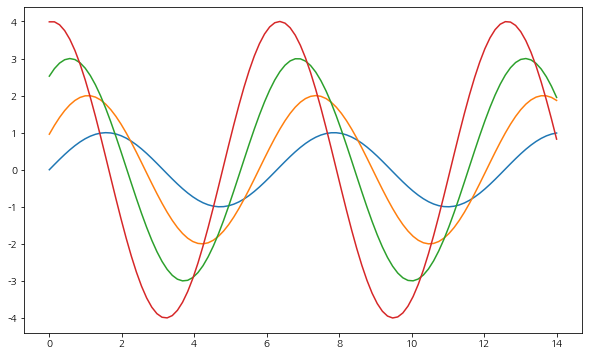

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

x = np.linspace(0, 14, 100)
y1 = np.sin(x)
y2 = 2*np.sin(x+0.5)
y3 = 3*np.sin(x+1.0)
y4 = 4*np.sin(x+1.5)

plt.figure(figsize = (10,6))
plt.plot(x,y1, x,y2, x,y3, x,y4)
plt.show()

기본인데도 색감이 괜찮습니다.

`Seaborn`은 `whitegrid`라는 스타일을 지원합니다.

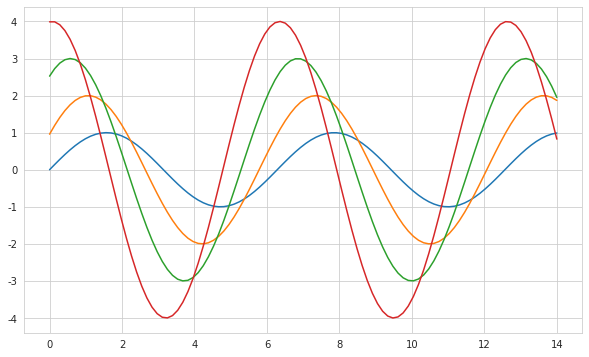

In [38]:
sns.set_style("whitegrid")

plt.figure(figsize = (10,6))
plt.plot(x,y1, x,y2, x,y3, x,y4)
plt.show()

또한 Seaborn은 연습할 만한 데이터셋을 몇 개 가지고 있습니다.

`Tips`라는 요일별 점심, 저녁, 흡연여부와 식사금액과 팁을 정리한 데이터셋 입니다.

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

In [40]:
tips = sns.load_dataset("tips")
tips.head(5)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


boxplot으로 x축에는 요일로, y축에는 전체 금액을 그릴 수 있습니다.

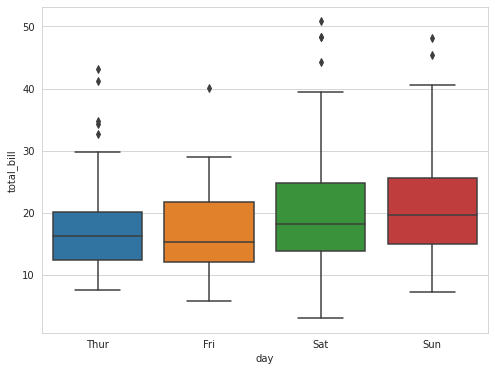

In [41]:
plt.figure(figsize = (8,6))
sns.boxplot(x = 'day', y = 'total_bill', data = tips)
plt.show()

더 놀라운것은 `hue`라는 옵션을 이용해서 구분할 수도 있습니다.
- yes / no의 smoker를 포함하여 두개로 구분
- 미리 준비된 palette로 색상을 지정할 수 있습니다.

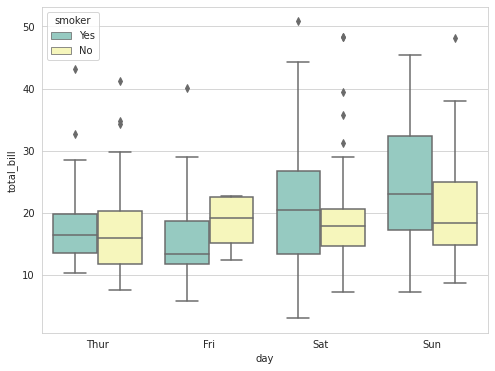

In [42]:
plt.figure(figsize = (8,6))
sns.boxplot(x = 'day', y = 'total_bill', hue = 'smoker', data = tips, palette = 'Set3')
plt.show()

이번에는 `darkgrid` 스타일로하고, `lmplot`을 그립니다.
- 데이터를 scatter처럼 그리고 직선으로 regression한 그림도 같이 그려주고 유효범위도 ci로 잡아줍니다.

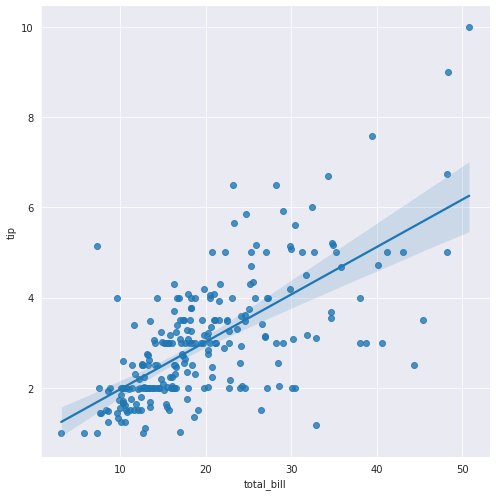

In [43]:
sns.set_style("darkgrid")
sns.lmplot(x = "total_bill", y = "tip", data = tips, size = 7)
plt.show()

또, `lmplot`도 `hue옵션을 가질 수 있으며 미리 준비된 palette로 색상을 지정할 수 있습니다.

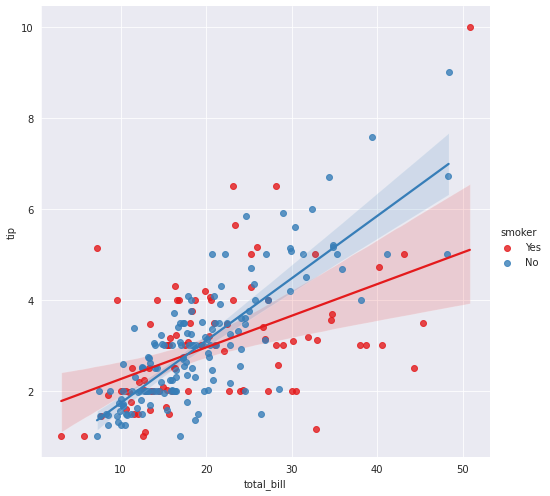

In [44]:
sns.lmplot(x = 'total_bill', y = 'tip', hue = 'smoker', data = tips, palette = 'Set1', size = 7)
plt.show()

이번에는 연도 및 월별 항공기 승객수를 기록한 데이터를 가져오겠습니다.

In [45]:
flights = sns.load_dataset("flights")
flights.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


`pivot`기능으로 간편하게 월별, 연도별로 구분할 수 있습니다. 앞서 언급했다 시피 `pivot`을 상상할 수 만 있다면 꽤 유용한 결과를 얻습니다.

In [46]:
flights = flights.pivot("month", 'year', 'passengers')
flights.head()

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472


`heatmap`이라는 도구를 이용하면 이런 종류의 데이터는 그 경향을 설명하기 참 좋습니다.
- `annot = True` : 네모칸에 수치 표시
- `annot = False`: 네모칸에 수치 미표시
- `fmt` : 뭔지 잘은 모르겠지만.. 하면 숫자가 승으로 됨

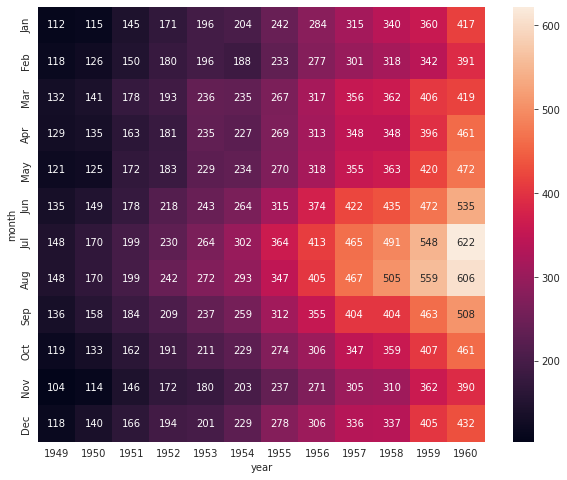

In [47]:
plt.figure(figsize = (10,8))
sns.heatmap(flights, annot = True, fmt = 'd')
plt.show()

이번에는 머신러닝에서 중요하게 다뤄지는 아이리스 꽃에 대한 데이터를 가지고 옵니다. 꽃잎, 꽃받침의 너비와 폭을 가지고 그 종을 구분할 수 있는지를 알아봅니다.

In [48]:
iris = sns.load_dataset('iris')
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


여기서는 `pairplot`이라는 정말 깔끔한 명령이 있습니다.

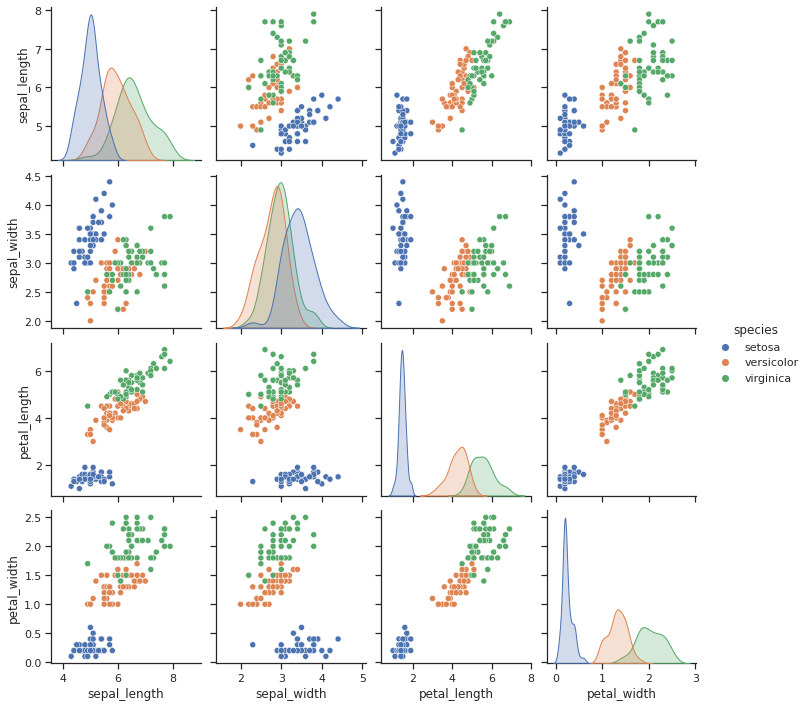

In [49]:
sns.set(style = 'ticks')

sns.pairplot(iris, hue = "species")
plt.show()

## 2-8 범죄 데이터 시각화하기

방금 학습한 시각화 도구인 Seaborn을 이용해서 뭔가 성과를 얻어보려고 합니다. (한글폰트 첨부)

`pairplot`으로 강도, 살이느 폭력 간의 상관관계를 그래프로 보겠습니다.

In [ ]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

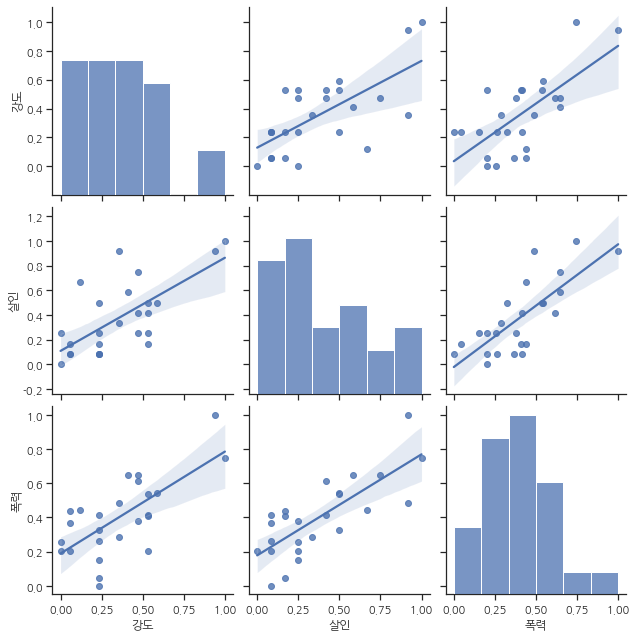

In [66]:
sns.pairplot(crime_anal_norm, vars = ['강도', '살인', '폭력'], kind='reg', size=3)
plt.show()

강도와 폭력, 살인과 폭력, 강도와 살인 모두 양의 상관관계를 보입니다.

인구수와 CCTV개수, 그리고 살인과 강도에 대해 조사해 보겠습니다.

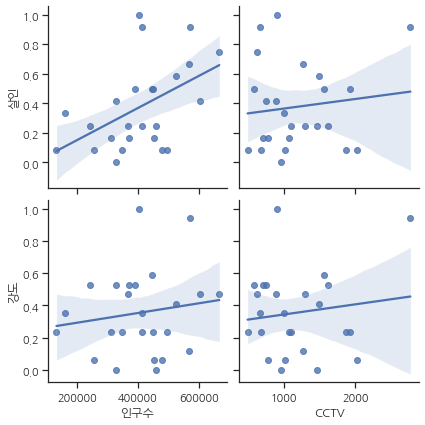

In [67]:
sns.pairplot(crime_anal_norm, x_vars = ['인구수', 'CCTV'],
             y_vars = ['살인', '강도'], kind = 'reg', size=3)

plt.show()

전체적인 상관계수는 CCTV와 살인의 관계가 낮을지 몰라도 CCTV가 없을 때 살인이 많이 일어나는 구간이 있습니다. 즉, CCTV개수를 기준으로 좌측면에 살인과 강도의 높은 수를 갖는 데이터가 보입니다.

살인 및 폭력 검거율과 CCTV의 관계를 보겠습니다.

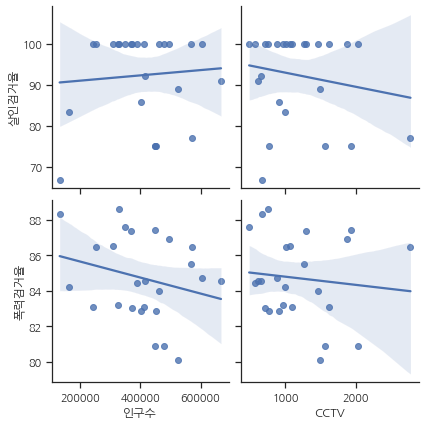

In [68]:
sns.pairplot(crime_anal_norm,
              x_vars = ['인구수', 'CCTV'],
              y_vars = ['살인검거율', '폭력검거율'], kind = 'reg', size = 3)

plt.show()

하지만 폭력 검거율과 CCTV관계가 양의 상관관계가 아닙니다. 오히려 음의 상관계수도 보입니다. 또 인구수와 살인 및 폭력 검거율도 음의 상관관계가 관찰됩니다.

이 쯤에서 검거율의 합계인 검거항목 최고 값을 100으로 한정하고 그 값으로 정렬합니다.

In [69]:
tmp_max = crime_anal_norm['검거'].max()
crime_anal_norm['검거'] = crime_anal_norm['검거'] / tmp_max *100
crime_anal_norm_sort = crime_anal_norm.sort_values(by = '검거', ascending = False)
crime_anal_norm_sort.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
도봉구,0.000000,0.235294,0.083333,0.000000,0.000000,100.000000,100.0,100.0,44.967074,87.626093,348646.0,485,0.063725,100.000000
금천구,0.141210,0.058824,0.083333,0.180840,0.202717,80.794702,100.0,100.0,56.668794,86.465433,255082.0,1015,0.133385,97.997139
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.0,100.0,60.114504,84.752105,603772.0,884,0.466789,96.572809
광진구,0.397695,0.529412,0.166667,0.704342,0.406864,91.666667,100.0,100.0,42.200925,83.047619,372164.0,707,0.440996,96.375820
동대문구,0.204611,0.470588,0.250000,0.329386,0.379335,84.393064,100.0,100.0,41.090358,87.401884,369496.0,1294,0.326784,95.444250


이를 heatmap 으로 그려보겠습니다.

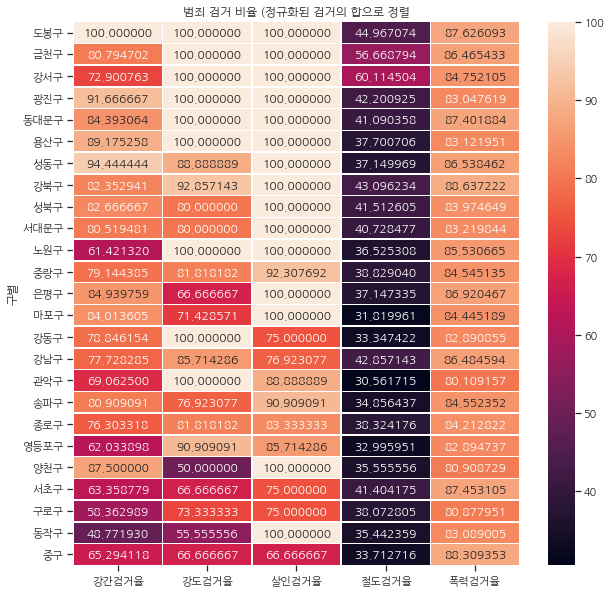

In [70]:
target_col = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']

plt.figure(figsize = (10, 10))
sns.heatmap(crime_anal_norm_sort[target_col], annot = True, fmt = 'f', linewidths = .5)
plt.title('범죄 검거 비율 (정규화된 검거의 합으로 정렬')
plt.show()

결과를 보면 절도 검거율은 다른 검거율에 비해 낮다는 것을 알 수 있습니다. 그리고 그래프의 하단으로 갈수록 검거율이 낮은데 그 속에 강남3구 중에서 '서초구'가 보입니다. 전반적으로 검거율이 우수한 구는 '도봉구', '광진구', '성동구'로 보입니다. 

이번에는 발생건수의 합으로 정렬해서 heatmap으로 관찰해보겠습니다.

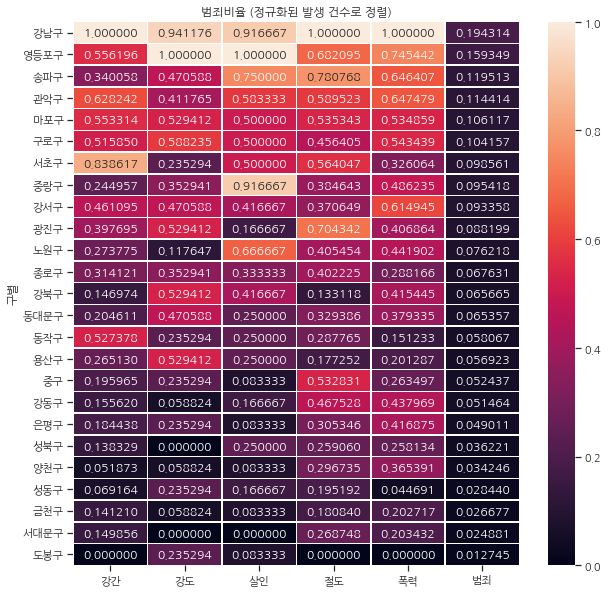

In [71]:
target_col = ['강간', '강도', '살인', '절도', '폭력', '범죄']

crime_anal_norm['범죄'] = crime_anal_norm['범죄'] / 5
crime_anal_norm_sort = crime_anal_norm.sort_values(by = '범죄', ascending = False)
plt.figure(figsize = (10,10))

sns.heatmap(crime_anal_norm_sort[target_col], annot = True, fmt = 'f', linewidths = .5)
plt.title('범죄비율 (정규화된 발생 건수로 정렬)')
plt.show()

발생 건수로 보니 '강남구', '양천구', '영등포구'가 발생 범죄 건수가 높습니다. 그리고 '송파구'와 '서초구'도 낮다고 볼 수 없습니다. 그렇다면 정말 강남 3구가 안전하다고 할 수 있을지 의문이 생깁니다.

일단 여기까지 하고 저장합니다. 이제 또 우리는 신세계로 진입해야한다고 합니다.

In [72]:
crime_anal_norm.to_csv('/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/02. crime_in_Seoul_final.csv', sep = ',', encoding = 'utf-8')

## 2-9 지도 시각화 도구 - Folium

지금처럼 강남 3구의 안정성을 이야기하면서 범죄율이나 검거율을 지도에 그릴 수 있다면 정말 매력적인 일입니다.

많은 지도 시각화 도구가 있지만, 여기서는 Foilum 라이브러리를 다루도록 한다고 합니다. `pip install folium`을 입력하여 folium을 설치합니다. 간편하게 folium의 공식페이지에 있는 튜토리얼을 확인할 수 있습니다.

In [73]:
import folium

그냥 위도와 경도 정보를 주면 지도를 그려줍니다. (혹시 하얗게 표시된다면, 크롬을 사용중인지 확인)

In [74]:
map_osm = folium.Map(location=[45.5236, -122.6750])
map_osm

`zoom_start`라는 옵션으로 확대 비율을 정의할 수도 있습니다.

In [75]:
stamen = folium.Map(location = [45.5236, -122.6750], zoom_start = 13)
stamen

`tiles` 옵션으로 이런 모양도 만들 수 있습니다.

In [76]:
stamen = folium.Map(location = [45.5236, -122.6750], tiles='Stamen Toner', zoom_start=13)
stamen

이번에는 지도를 그리고 그 상태에서 원하는 좌표에 Marker명령으로 마크를 찍을 수도 있습니다. 그리고 CircleMarker 명령으로 반경(radius)과 색상(color)을 지정하면 원을 그려줍니다.

In [77]:
map_2 = folium.Map(location = [45.5236, -122.6750], tiles='Stamen Toner',
                    zoom_start = 13)
folium.Marker([45.5244, -122.6699], popup = 'The Waterfront').add_to(map_2)
folium.CircleMarker([45.5215, -122.6261], radius = 50,
                    popup = 'Laurelhurst Park', color = '#3186cc',
                    fill_color = '#3186cc',).add_to(map_2)

map_2

여기서 부터 실행하는 경우를 위해 다시 모듈을 불러옵니다.

In [78]:
import folium
import pandas as pd

2012년 10월 기준 미국의 주별 실업률 파일을 불러와 이를 시각화 하려 합니다.

In [79]:
state_unemployment = '/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/02. folium_US_Unemployment_Oct2012.csv'

state_data = pd.read_csv(state_unemployment)
state_data.head()

,State,Unemployment
0,AL,7.1
1,AK,6.8
2,AZ,8.1
3,AR,7.2
4,CA,10.1


이를 시각화 하기 위해서는 02. folium_us-states.json이 필요합니다.

아래는 json파일의 생김새 입니다.
- id로 주별 고유 ID, 주 이름, 그리고 주 경계선 기준으로 좌표가 있습니다.
![img](https://drive.google.com/uc?id=1PD8oDKNHyKe2kDxHa3JZSYepeNlw_TGZ)

state_geo라는 변수에 json 파일 경로를 담고, folium에서 `choropleth`명령으로 json파일과 지도에 표현하고 싶은 데이터를 입력하고, key_on 옵션으로 지도의 id를 알려주면 됩니다. 여기서, 지도의 id가 서로 중복되지 않아야 합니다.

In [81]:
state_geo = '/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/02. folium_us-states.json'

map = folium.Map(location = [40,-98], zoom_start=4)
map.choropleth(geo_data=state_geo, data = state_data,
               columns = ['State', 'Unemployment'],
               key_on = 'feature.id',
               fill_color = 'YlGn',
               legend_name = 'Unemployment Rate (%)')

map

그러면 위 그림처럼 실업률이 colormap으로 표현된 결과를 얻을 수 있습니다.

## 2-10 서울시 범죄율에 대한 지도 시각화

이제 우리가 열심히 다듬었던 자료를 시각화 해 보겠습니다. 항상 난관이 있습니다. 서울시 구별 경계선을 그릴 수 있는 파일이 있어야합니다. 이건 우리가 직접 만들 수 있는 범위를 넘어섭니다. 때문에 우선 gihub에서 json파일을 얻어옵니다.

먼저 json파일을 로딩합니다.

In [82]:
import json
geo_path = '/content/drive/MyDrive/파이썬으로_데이터_주무르기/data/02. skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding = 'utf-8'))

그리고 서울시의 중심의 위도와 경도 정보를 먼저 입력하고 경계선을 그리는데, 컬러맵은 살인 발생 건수로 지정합니다.

In [84]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                 tiles = 'Stamen Toner')
map.choropleth(geo_data = geo_str,
               data = crime_anal_norm['살인'],
               columns = [crime_anal_norm.index, crime_anal_norm['살인']],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.id')

map

그 결과를 보면 살인 발생건수가 강남 3구가 안전하다고 보기는 어려울 것 같습니다.

특히 강간 발생 건수로 다시 그려보면,

In [85]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                 tiles = 'Stamen Toner')
map.choropleth(geo_data = geo_str,
               data = crime_anal_norm['강간'],
               columns = [crime_anal_norm.index, crime_anal_norm['강간']],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.id')

map

더더욱 강남 3구가 안전한지 의심이 듭니다.

이제 이전에 만들어둔 범죄 발생 건수 전체에 대해 살펴보면,

In [86]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                 tiles = 'Stamen Toner')
map.choropleth(geo_data = geo_str,
               data = crime_anal_norm['범죄'],
               columns = [crime_anal_norm.index, crime_anal_norm['범죄']],
               fill_color = 'PuRd', #PuRd, YlGnBu
               key_on = 'feature.id')

map

역시 강남 3구와 강서구 주변이 범죄 발생 건수가 높은 것으로 나타나고 있습니다. 그러나 인구수를 고려해야 할것 같습니다. 즉, 인구 대비 범죄 발생 비율을 알아보는 것입니다. 그래서 범죄 전체 발생건수에 인구수를 나누고 소수점 밑으로 가서 적절한 값을 곱하는 것으로 하겠습니다. 

In [89]:
tmp_criminal = crime_anal_norm['살인'] / crime_anal_norm['인구수'] * 1000000

map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                 tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str,
               data = tmp_criminal,
               columns = [crime_anal.index, tmp_criminal],
               fill_color = 'PuRd', #PuEd, YlGnBu
               key_on = 'feature.id')

map

인구 대비 범죄 발생 건수로 보면 강남 3구가 1위는 아니지만 안전도가 제일 높다고 말할 수는 없을 것 같습니다. 그런데 중구와 종로구의 범죄율이 엄청 높아졌습니다. 아마 거주 인구는 적고, 관광지여서 그런게 아닐지 추측해봅니다.

## 2-11 서울시 결찰서별 검거율과 구별 범죄 발생율을 동시에 시각화하기

이제 조금 더 진행해서 경찰서별 검거율과 방금 전까지 수행항 범죄 발생율을 동시에 표현하는게 효과적일 것 같습니다.